In [1]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리

겟아웃 장면 2개로 실험

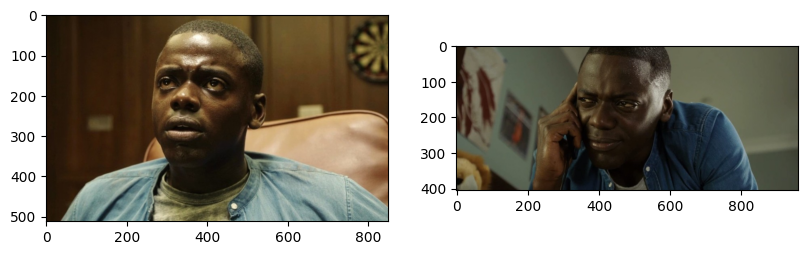

In [2]:
# 이미지 확인하기

my_image_path_list = ['p1.jpg', 'p2.jpg']

plt.figure(figsize=(15, 5))
for i, path in enumerate(my_image_path_list):
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img_rgb)

plt.show()

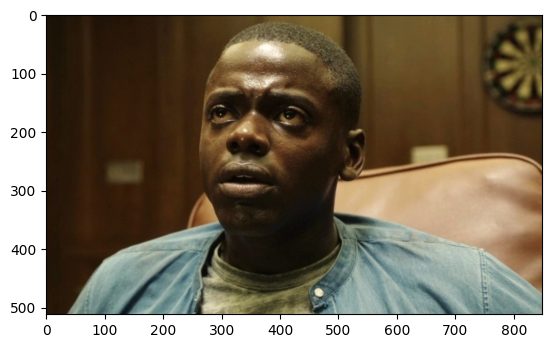

In [3]:
# 이미지 1번 준비

my_image_path = 'p1.jpg'

img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy()


img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(230, 82) (498, 350)]]


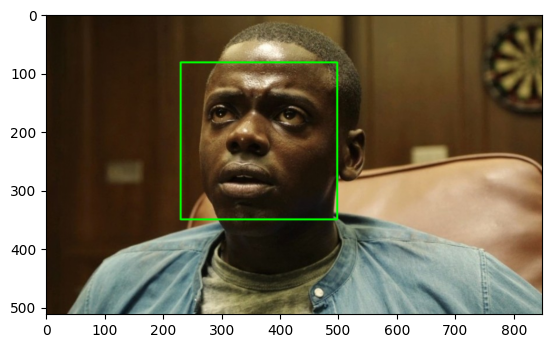

In [4]:
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

# bounding box 추출하기

img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_show, 1)   # (image, num of image pyramid)

print(dlib_rects)

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴을 잘 감지하는 것을 확인

### Object keypoint estimation 알고리즘

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

- top-down : bounding box를 찾고 box 내부의 keypoint를 예측

- bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

이번 예제에서는 1번 방식을 다룹니다.

### Dlib landmark localization
잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾습니다.  
이 때 점의 개수는 데이터셋과 논문마다 다릅니다.  
예를 들면, AFLW 데이터셋은 21개를 사용하고 ibug 300w 데이터셋은 68개를 사용합니다.
dlib는 ibug 300w 데이터셋으로 학습되었습니다.

In [5]:
# 모델 다운로드 후 불러내기

model_path = 'shape_predictor_68_face_landmarks.dat'

landmark_predictor = dlib.shape_predictor(model_path)

In [6]:
# 랜드마크 찾기

 # 랜드마크의 위치를 저장할 list 생성
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


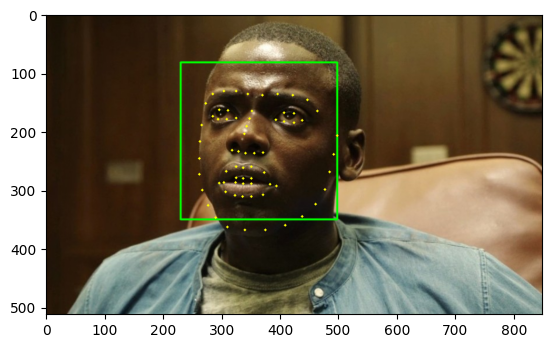

In [7]:
# 랜드마크 확인


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [8]:
# 코의 좌표와 얼굴 가로의 길이

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 밑부분에서 바로 윗 부분 선택
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(339, 204)
(x,y) : (339,70)
(w,h) : (269,269)


### 고양이 스티커 붙이기

In [9]:
# 고양이 스티커 불러오기

sticker_path = 'cat.png'
img_sticker = cv2.imread(sticker_path)
# 스티커 이미지 조정
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(269, 269, 3)


In [10]:
# 좌표 설정
refined_x = landmark[30][0] - (w//2)  # 콧대 끝의 x좌표 - 스티커 width/2
refined_y = landmark[30][1] - (h//2) # 콧대 끝의 y좌표 - 스티커 height/2

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (205,70)


얼굴 좌표가 너무 위에 있으면 마이너스 좌표가 나옴 ⇒ 이미지 범위 밖의 왕관은 잘라야 한다.
스티커가 원본 이미지의 범위를 넘어가는 경우 하나 더 : 스티커의 시작점 + 스티커 사진의 크기가 원본 이미지의 크기보다 큰 경우이다.

In [11]:
# 좌표 벗어나는 부분 삭제
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (205,70)


In [12]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# addWeighted를 적용하기 위해 np.where 코드 수정
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,cv2.addWeighted(sticker_area, 0.5, img_sticker, 0.5, 0)).astype(np.uint8)

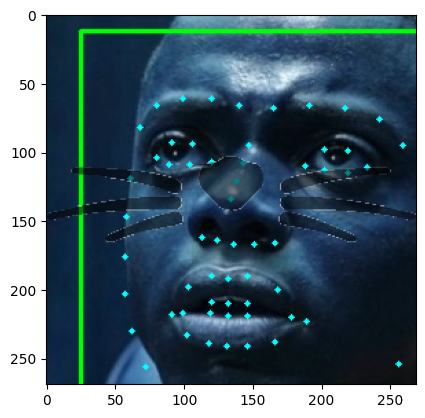

In [13]:
plt.imshow(sticker_area)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

오류 : 스티커의 배경이 사라지지 않는 현상?
문제점 확인 : 예제 문제는 배경색이 흰색인 스티커였는데 프로젝트 스티커는 배경색이 투명   
-> np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)에서
 np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

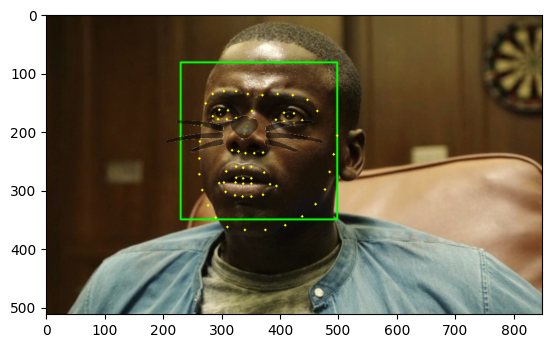

In [14]:
# 얼굴 좌표에 맞게 스티커 붙여졌는지 확인
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

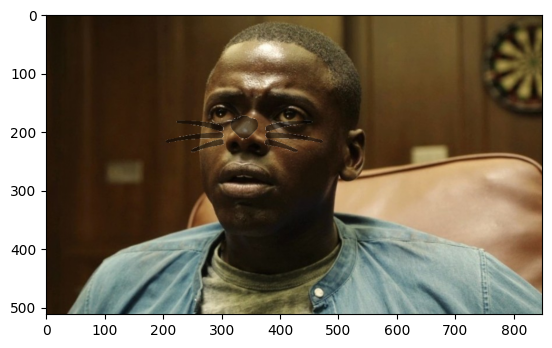

In [15]:
# bounding box와 랜드마크 삭제한 이미지 출력

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,cv2.addWeighted(sticker_area, 0.5, img_sticker, 0.5, 0)).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 다른 이미지로 실험하기

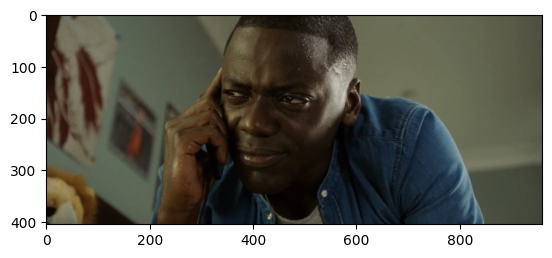

In [31]:
# 이미지 2번 준비

my_image_path = 'p2.jpg' # 본인 이미지가 있는 경로를 가지고 온다.

img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)


rectangles[]


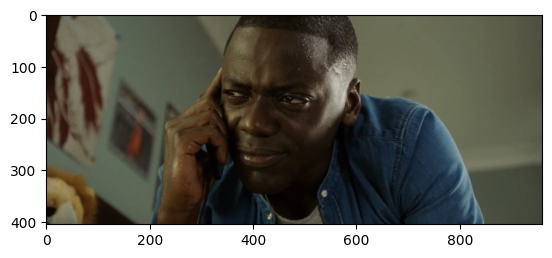

In [32]:
# bounding box 추출하기

dlib_rects = detector_hog(img_show, 1)   # (image, num of image pyramid)

# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴을 감지하지 못함  
-> 전처리 시도

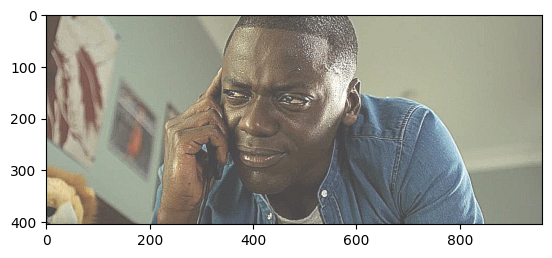

In [33]:
# 전처리 해보기

# 샤프닝 필터 정의 (강한 샤프닝)
kernel = np.array([[ -1,  -1,  -1],
                   [ -1,   9,  -1],
                   [ -1,  -1,  -1]])

# 샤프닝 필터 적용
img_sharpen = cv2.filter2D(src=img_rgb, ddepth=-1, kernel=kernel)

# 밝기 조절 (양수로 밝게, 음수로 어둡게)
brightness_value = 70
img_brig = cv2.convertScaleAbs(img_sharpen, alpha=1, beta=brightness_value)
img_show = img_brig.copy()

# 이미지 출력
plt.imshow(img_show)
plt.show()

rectangles[]


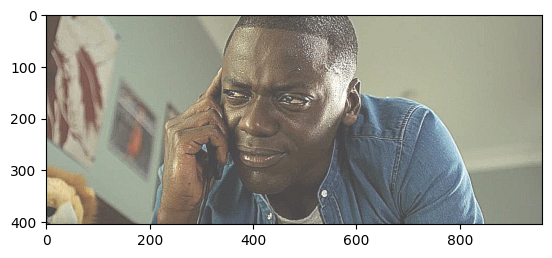

In [34]:
# bounding box 추출하기

dlib_rects = detector_hog(img_brig, 1)   # (image, num of image pyramid)

# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_brig, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

plt.imshow(img_brig)
plt.show()

밝기와 선명도 조절로 바운딩 박스 추출 실패


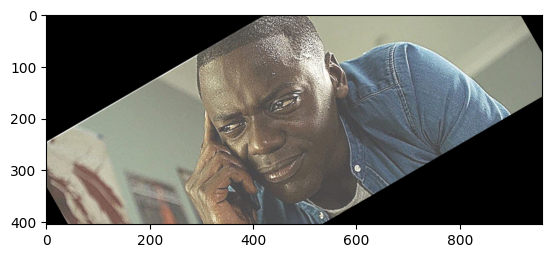

In [35]:
# 이미지 회전해보기

center = (img_brig.shape[1]//2, img_brig.shape[0]//2)               # 이미지 중심점 좌표
angle = 30                                                          # 회전시킬 각도
scale = 1                                                           # 회전 후 확대시키는 정도 (기본값 1)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)     # 회전 매트릭스 생성
img_rot = cv2.warpAffine(img_brig, rotation_matrix, (img_brig.shape[1], img_brig.shape[0]))
img_show = img_rot.copy()

plt.imshow(img_show)
plt.show()


rectangles[[(315, 118) (538, 341)]]


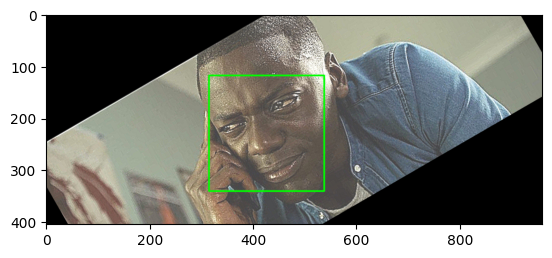

In [36]:
# bounding box 추출하기

dlib_rects = detector_hog(img_rot, 1)   # (image, num of image pyramid)

# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_rot, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림


plt.imshow(img_rot)
plt.show()

각도로 회전한 후 바운딩 박스 추출 성공

In [37]:
# 랜드마크 찾기

 # 랜드마크의 위치를 저장할 list 생성
list_landmarks = []

# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rot, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


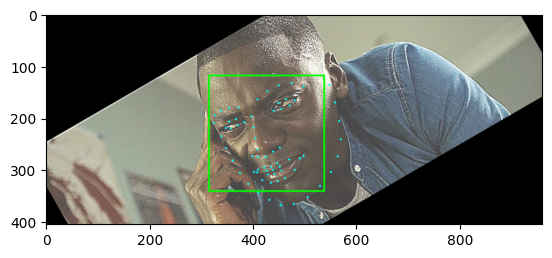

In [38]:
# 랜드마크 확인

# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_rot, point, 2, (0, 255, 255), -1)

plt.imshow(img_rot)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

In [39]:
# 코의 좌표와 얼굴 가로의 길이

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(409, 261)
(x,y) : (409,149)
(w,h) : (224,224)


In [40]:
# 고양이 스티커 불러오기

img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(224, 224, 3)


고양이 스티커 전처리하기

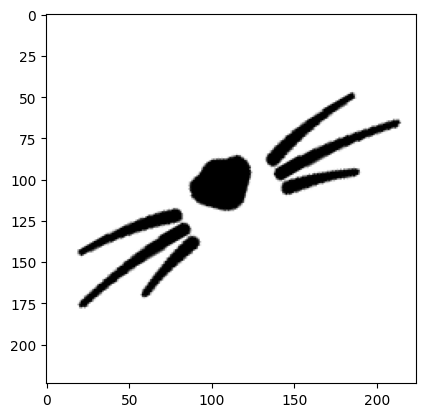

In [41]:
#같은 각도로 회전하기

center = (img_sticker.shape[1]//2, img_sticker.shape[0]//2)         # 이미지 중심점 좌표
angle = 30                                                          # 회전시킬 각도
scale = 1                                                           # 회전 후 확대시키는 정도 (기본값 1)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)     # 회전 매트릭스 생성
sticker_rot = cv2.warpAffine(img_sticker, rotation_matrix, (img_sticker.shape[1], img_sticker.shape[0]),borderValue=(255,255,255))    # borderValue : 회전할 때 배경색 설정

plt.imshow(sticker_rot)
plt.show()

In [42]:
# 좌표 설정
refined_x = landmark[30][0] - (w//2)  # 콧대 끝의 x좌표 - 스티커 width/2
refined_y = landmark[30][1] - (h//2) # 콧대 끝의 y좌표 - 스티커 height/2

# 좌표 벗어나는 부분 삭제
print (f'(x,y) : ({refined_x},{refined_y})')

if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (297,149)
(x,y) : (297,149)


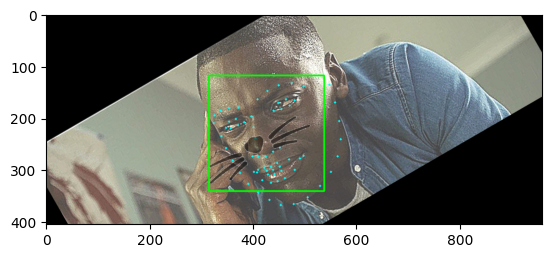

In [43]:
#스티커 붙이기
sticker_area = img_rot[refined_y:refined_y+sticker_rot.shape[0], refined_x:refined_x+sticker_rot.shape[1]]

img_rot[refined_y:refined_y+sticker_rot.shape[0], refined_x:refined_x+sticker_rot.shape[1]] = \
    np.where(sticker_rot==255,sticker_area,cv2.addWeighted(sticker_area, 0.5, sticker_rot, 0.5, 0)).astype(np.uint8)
plt.imshow(img_rot)
plt.show()


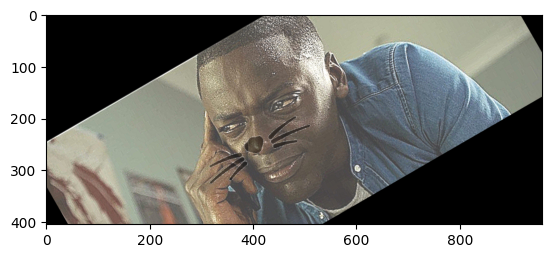

In [44]:
# bounding box와 랜드마크 삭제한 이미지 출력

sticker_area = img_show[refined_y:refined_y+sticker_rot.shape[0], refined_x:refined_x+sticker_rot.shape[1]]

img_show[refined_y:refined_y+sticker_rot.shape[0], refined_x:refined_x+sticker_rot.shape[1]] = \
    np.where(sticker_rot==255,sticker_area,cv2.addWeighted(sticker_area, 0.5, sticker_rot, 0.5, 0)).astype(np.uint8)

plt.imshow(img_show)
plt.show()

회고 : 웬만한 사람의 윤곽을 잘 구분하지만 화질을 많이 낮춰서 하거나 윤곽 구분이 거의 나지 않는 사람의 경우에는 랜드마크를 잡아내지 못하였다.  
겟아웃 등장인물 같은 경우, 사진에 따라 결과가 달랐다.  
밝기와 선명도를 바꾸어 봤지만 유의미한 효과는 없는 듯 했다. 수업 이후에도 실험이 더 필요해 보인다.

2차 회고 : 얼굴의 밝기와 선명도 조절이 얼굴을 감지하는 것에 효과가 없었다.  
하지만 얼굴의 각도가 얼굴 감지에 효과가 있는 것을 확인하였다.